In [151]:
import pandas as pd
import altair as alt
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

import sys
import os
import numpy as np
import pandas as pd
sys.path.insert(0, '../../')

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV 
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, recall_score, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler


from library.notebook_api.data_loader import CombinedDataLoader, ModelDataLoader

alt.data_transformers.enable("vegafusion")
alt.renderers.enable('default')



RendererRegistry.enable('default')

In [105]:
full_model_data = ModelDataLoader('002')
full_model_data.df.to_csv('output.csv', index=False) 

In [106]:
data_df = pd.read_csv('/Users/tetyananesdill/music_modeling_capstone/notebooks/data_creation/output.csv')

# Examine the data & features

## Check missing values

In [107]:
missing_data = data_df.isnull().sum().reset_index()
missing_data.columns = ['Column', 'Missing Count']

missing_chart = alt.Chart(missing_data).mark_bar().encode(
    x='Column:N',
    y='Missing Count:Q',
    color = 'Missing Count:Q'
).properties (title='# of missing values', height=300, width=750)

missing_chart

alt.Chart(...)

## Check correlation between variables

/var/folders/4h/jhj1r0hs299ft55gtj87plz40000gn/T/ipykernel_8500/4212914176.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix = data_df.corr()


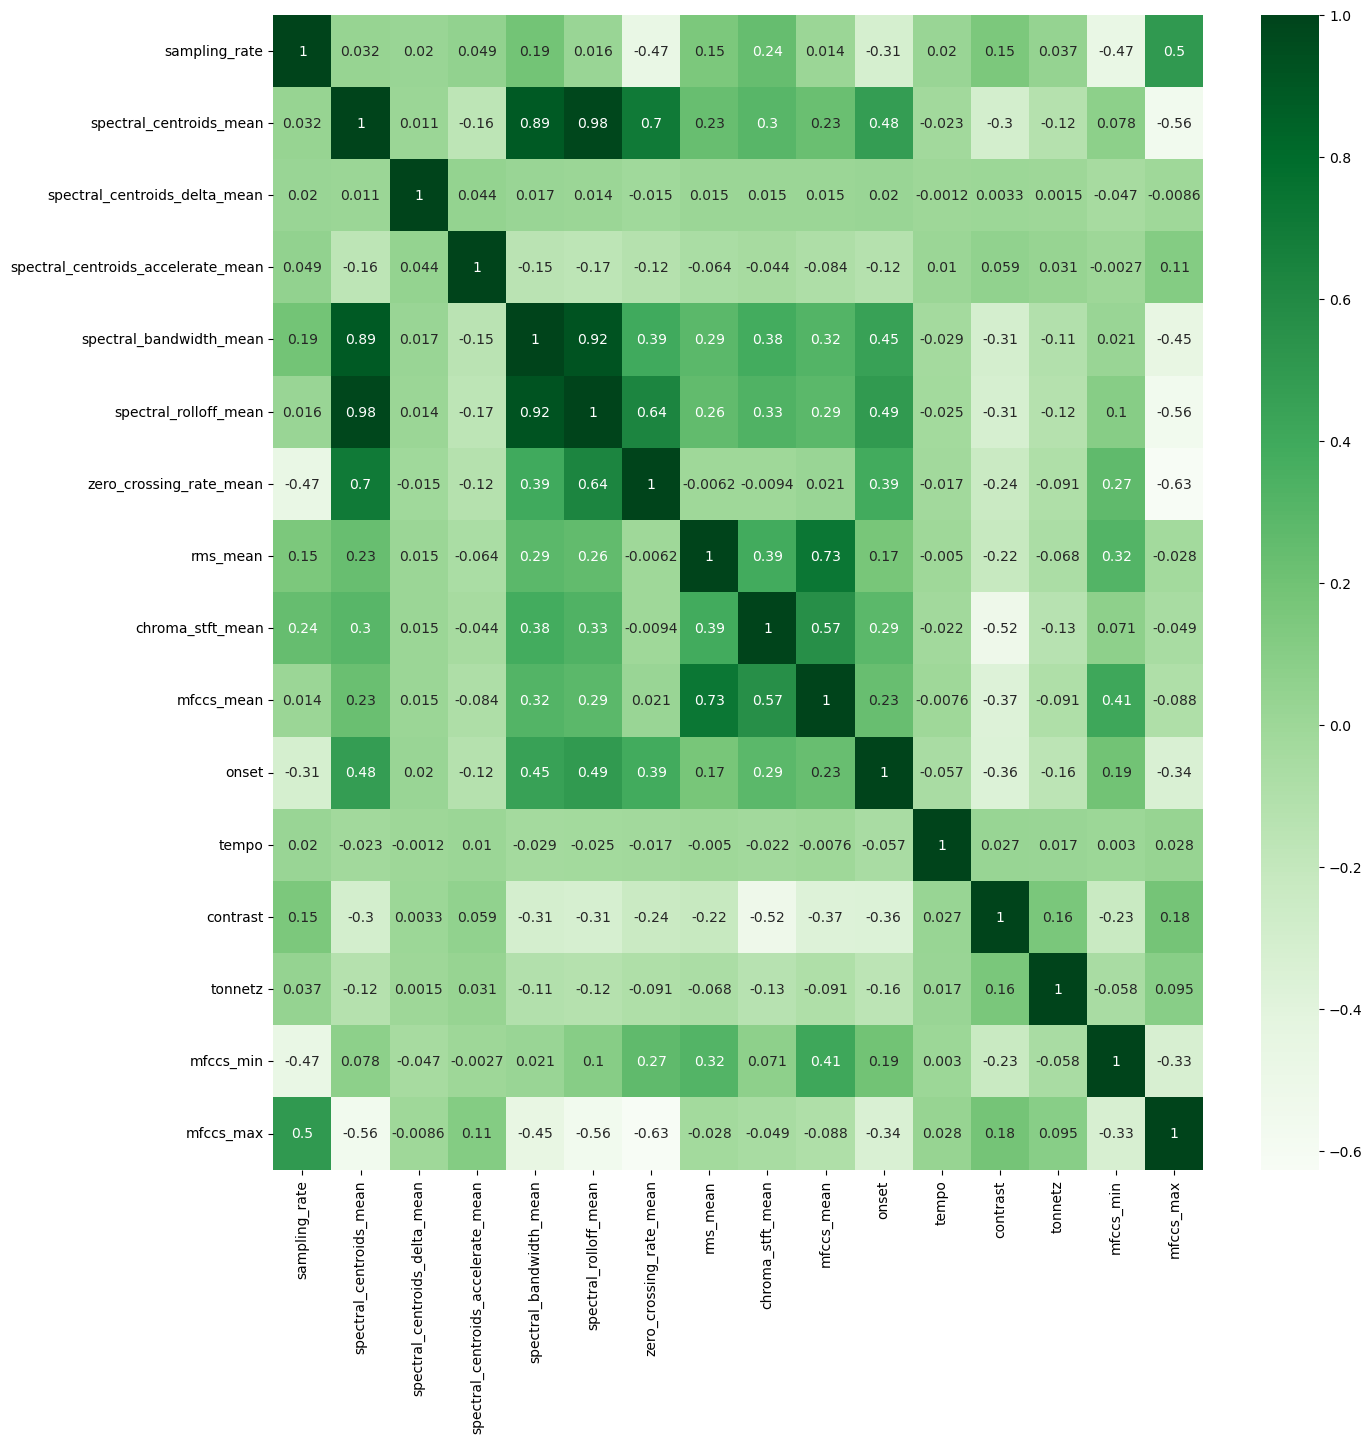

In [108]:
# check correlation between vars
matrix = data_df.corr()

plt.figure(figsize=(15, 15))

heatmap = sns.heatmap(matrix, cmap="Greens", annot=True)

plt.show()


certain features are highly correlated; we might want to take a note of that as it might be important depending on what algorithm we use. 

spectral bandwidth; spectral roll off; spectral centroids are highly correlated 

## Check var distribution be genre 

In [109]:
def box_plot(y_col):
    chart = alt.Chart(data_df).mark_boxplot(extent="min-max").encode(
        alt.X("label:N"),
        alt.Y(y_col).scale(zero=False),
        alt.Color("label:N").legend(None),
    )
    return chart

#box_plot('sspectral_centroids_mean:Q') & box_plot('rms_mean') &  box_plot('mfccs_mean')| box_plot('spectral_centroids_delta_mean') & box_plot('spectral_centroids_accelerate_mean') & box_plot('spectral_rolloff_mean') | box_plot('zero_crossing_rate_mean') & box_plot('chroma_stft_mean') & box_plot('spectral_bandwidth_mean')


In [110]:
#new vars
box_plot('tempo') & box_plot('tonnetz')  | box_plot('onset') & box_plot('contrast') | box_plot('mfccs_min') & box_plot('mfccs_max')

alt.HConcatChart(...)

two variables (spectral_centroids_accelerate and spectral_centroids_delta) do not show much variablity by genre. These variables might not be the best predictors of a genre. Consider exluding these two variables and maybe picking different ones. 


## Distribution by var and genre 

In [111]:
selection = alt.selection_multi(fields=['label'])
color = alt.condition(selection,
                      alt.Color('label:N', legend=None),
                      alt.value('lightgray'))

opacity = alt.condition(selection, alt.value(1.0), alt.value(0.1))


scatter = alt.Chart(data_df).mark_point().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color=color,
    opacity=opacity,
    tooltip='label:N'
).properties(
    width=150,
    height=150
).repeat(
    row=['tonnetz', 'contrast', 'tempo', 'onset'],
    column=['onset','tempo', 'contrast','tonnetz']
)

legend = alt.Chart(data_df).mark_point().encode(
    y=alt.Y('label:N', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selection
)

(scatter | legend)

/var/folders/4h/jhj1r0hs299ft55gtj87plz40000gn/T/ipykernel_8500/1774960293.py:1: AltairDeprecationWarning: Deprecated in `altair=5.0.0`. Use selection_point instead.
  selection = alt.selection_multi(fields=['label'])
/var/folders/4h/jhj1r0hs299ft55gtj87plz40000gn/T/ipykernel_8500/1774960293.py:26: AltairDeprecationWarning: Deprecated in `altair=5.0.0`. Use add_params instead.
  ).add_selection(


alt.HConcatChart(...)

it seems that some of these genres are all over the place.. hypothetically, it would be nice to see more of a pattern. but if you select such genres as 'experimental', it seems to be all over the place .. 

## Check class distribution 

In [112]:
class_dis = pd.DataFrame(data_df['label'].value_counts(normalize=True) * 100).reset_index()

alt.Chart(class_dis).mark_bar().encode(
    x=alt.X('label:Q', title=None),
    y=alt.Y('index:N', sort='-x', title=None),
    color='label:Q')

alt.Chart(...)

the classes are imbalanced, which might need to be remediated for a classificaiton algorithm. Minority class might not be correctly predicted. 

## Calculate distance between groups based on chroma_shift

In [113]:
sampled_df = data_df.groupby('label').sample(n=99)

def ec_distance(group1, group2):
    distance = np.sqrt(np.sum([(a-b)*(a-b) for a, b in zip(group1, group2)]))
    return distance


genres = data_df['label'].unique()

dist_df = {}
for i in genres:
    for j in genres:

        group1 = sampled_df[sampled_df['label']==i]['tempo']
        group2 = sampled_df[sampled_df['label']==j]['tempo']
        
        if i==j: 
            continue
        if (j,i) in dist_df:
            continue
        else:
            dist = ec_distance(group1, group2)
            dist_df[i,j] = round(dist,2)
        
dist_df_sorted = dict(sorted(dist_df.items(), key=lambda item: item[1]))

dist_df_top20 = pd.DataFrame(dist_df_sorted.items(), columns=['genres', 'similarity']).head(20)
dist_df_top20

genres  similarity
0      (experimental, soulrnb)      193.68
1               (pop, soulrnb)      208.41
2        (electronic, soulrnb)      208.99
3              (soulrnb, jazz)      208.99
4              (rock, soulrnb)      215.60
5         (classical, soulrnb)      218.47
6      (instrumental, soulrnb)      219.01
7              (folk, soulrnb)      220.85
8          (pop, experimental)      222.83
9         (folk, instrumental)      230.19
10        (instrumental, jazz)      235.14
11                 (pop, folk)      237.77
12  (experimental, electronic)      239.16
13    (international, soulrnb)      240.18
14   (instrumental, classical)      241.13
15        (rock, instrumental)      241.67
16           (rock, classical)      241.78
17   (experimental, classical)      246.94
18                (rock, jazz)      247.66
19        (experimental, jazz)      248.25

Text(0.5, 1.0, 'Most similar genre based on the tempo feature')

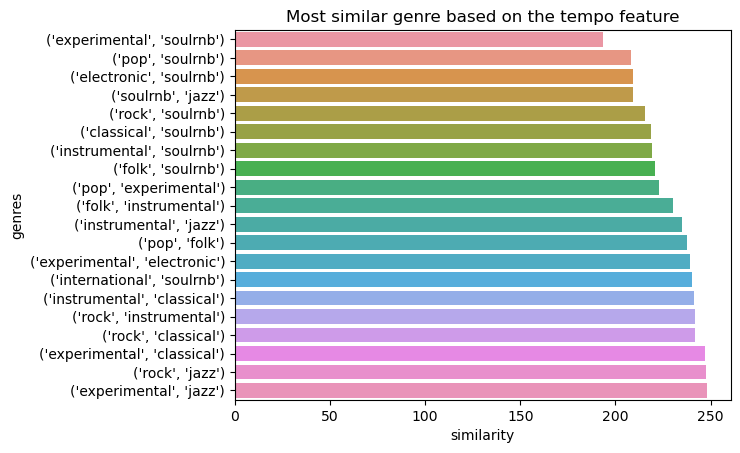

In [114]:
sns.barplot(x = 'similarity',
            y = 'genres',
            data = dist_df_top20)

plt.title("Most similar genre based on the tempo feature")

# Class imblanance remidiation using SMOTE

In [115]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

y = data_df['label']
x = data_df[['spectral_centroids_mean',
             'spectral_centroids_delta_mean',
             'spectral_centroids_accelerate_mean',
             'spectral_bandwidth_mean',
             'spectral_rolloff_mean',
             'zero_crossing_rate_mean',
             'rms_mean', 
             'chroma_stft_mean',
             'mfccs_mean',
            'tempo',
            'onset',
            'contrast',
            'tonnetz',
            'mfccs_min',
            'mfccs_max']]

x_smote, y_smote = smote.fit_resample(x, y)

y_smote.value_counts()

hiphop           1199
pop              1199
folk             1199
experimental     1199
rock             1199
international    1199
electronic       1199
instrumental     1199
blues            1199
classical        1199
country          1199
soulrnb          1199
jazz             1199
Name: label, dtype: int64

In [116]:
smote_df = x_smote.copy()
smote_df['label'] = y_smote

In [117]:
def ec_distance(group1, group2):
    distance = np.sqrt(np.sum([(a-b)*(a-b) for a, b in zip(group1, group2)]))
    return distance


genres = smote_df['label'].unique()

dist_df = {}
for i in genres:
    for j in genres:

        group1 = smote_df[smote_df['label']==i]['tempo']
        group2 = smote_df[smote_df['label']==j]['tempo']
        
        if i==j: 
            continue
        if (j,i) in dist_df:
            continue
        else:
            dist = ec_distance(group1, group2)
            dist_df[i,j] = round(dist,2)
        
dist_df_sorted = dict(sorted(dist_df.items(), key=lambda item: item[1]))

dist_df_top20 = pd.DataFrame(dist_df_sorted.items(), columns=['genres', 'similarity']).head(20)
dist_df_top20

genres  similarity
0        (experimental, soulrnb)      627.53
1           (classical, soulrnb)      648.86
2                (soulrnb, jazz)      654.49
3                (folk, soulrnb)      710.56
4        (instrumental, soulrnb)      719.45
5          (electronic, soulrnb)      745.11
6      (experimental, classical)      746.57
7              (classical, jazz)      747.69
8           (experimental, jazz)      761.35
9                (rock, soulrnb)      762.38
10                (pop, soulrnb)      762.78
11            (country, soulrnb)      779.35
12              (blues, soulrnb)      779.96
13             (folk, classical)      796.47
14     (instrumental, classical)      799.11
15          (folk, experimental)      805.49
16  (experimental, instrumental)      810.35
17       (electronic, classical)      814.31
18             (rock, classical)      814.74
19    (experimental, electronic)      818.98

Text(0.5, 1.0, 'Most similar genre based on the tempo feature')

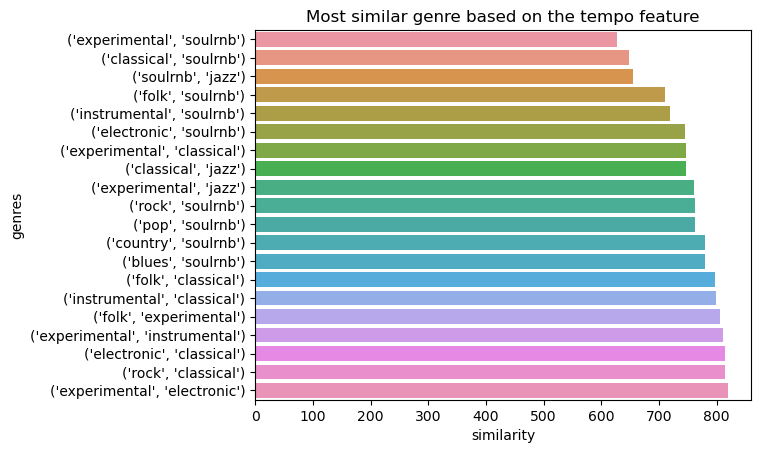

In [118]:
sns.barplot(x = 'similarity',
            y = 'genres',
            data = dist_df_top20)

plt.title("Most similar genre based on the tempo feature")

Distance value between classes increased

# Classificaiton 

## Original dataset with all vars 

In [119]:
y_original = data_df['label']
x_original = data_df[['spectral_centroids_mean',
             'spectral_centroids_delta_mean',
             'spectral_centroids_accelerate_mean',
             'spectral_bandwidth_mean',
             'spectral_rolloff_mean',
             'zero_crossing_rate_mean',
             'rms_mean', 
             'chroma_stft_mean',
             'mfccs_mean',
            'tempo',
            'onset',
            'contrast',
            'tonnetz',
            'mfccs_min',
            'mfccs_max']]

X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(x_original, y_original, test_size=0.2, random_state=42)

RandomForest = RandomForestClassifier(random_state=42)
RandomForest.fit(X_train_og, y_train_og)

y_pred_og = RandomForest.predict(X_test_og)

In [120]:
print(classification_report(y_test_og, y_pred_og))

               precision    recall  f1-score   support

        blues       0.72      0.81      0.76        16
    classical       0.79      0.83      0.81        18
      country       0.53      0.39      0.45        23
   electronic       0.53      0.44      0.48       193
 experimental       0.46      0.37      0.41       206
         folk       0.52      0.57      0.54       196
       hiphop       0.58      0.65      0.61       249
 instrumental       0.52      0.49      0.51       200
international       0.49      0.53      0.51       228
         jazz       0.50      0.50      0.50        16
          pop       0.37      0.33      0.35       198
         rock       0.53      0.62      0.57       242
      soulrnb       0.47      0.47      0.47        15

     accuracy                           0.51      1800
    macro avg       0.54      0.54      0.54      1800
 weighted avg       0.51      0.51      0.51      1800



## Full dataset/ smote for imbalanced classes

In [121]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(x_smote, y_smote, test_size=0.2, random_state=42)

RandomForest = RandomForestClassifier(random_state=42)
RandomForest.fit(X_train_smote, y_train_smote)

y_pred_smote = RandomForest.predict(X_test_smote)

In [122]:
print(classification_report(y_test_smote, y_pred_smote))

               precision    recall  f1-score   support

        blues       0.98      0.99      0.99       257
    classical       0.99      1.00      1.00       226
      country       0.94      1.00      0.97       248
   electronic       0.59      0.51      0.55       239
 experimental       0.51      0.47      0.49       232
         folk       0.57      0.68      0.62       260
       hiphop       0.60      0.66      0.63       239
 instrumental       0.58      0.57      0.58       244
international       0.54      0.56      0.55       232
         jazz       0.97      1.00      0.99       190
          pop       0.45      0.33      0.38       246
         rock       0.58      0.56      0.57       253
      soulrnb       0.94      1.00      0.97       252

     accuracy                           0.72      3118
    macro avg       0.71      0.72      0.71      3118
 weighted avg       0.71      0.72      0.71      3118



In [123]:
clf = DecisionTreeClassifier()

clf = clf.fit(X_train_smote,y_train_smote)

y_pred_smote_dt = clf.predict(X_test_smote)

In [124]:
print(classification_report(y_test_smote, y_pred_smote_dt))

               precision    recall  f1-score   support

        blues       0.89      0.88      0.89       257
    classical       0.98      0.95      0.96       226
      country       0.86      0.91      0.88       248
   electronic       0.40      0.34      0.37       239
 experimental       0.28      0.34      0.31       232
         folk       0.47      0.46      0.47       260
       hiphop       0.46      0.44      0.45       239
 instrumental       0.45      0.40      0.42       244
international       0.37      0.41      0.39       232
         jazz       0.82      0.90      0.86       190
          pop       0.27      0.26      0.26       246
         rock       0.39      0.36      0.38       253
      soulrnb       0.89      0.90      0.90       252

     accuracy                           0.58      3118
    macro avg       0.58      0.58      0.58      3118
 weighted avg       0.58      0.58      0.58      3118



In [153]:
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(X_train_smote,y_train_smote)
y_pred_smote_lm = lm.predict(X_test_smote)

In [154]:
print(classification_report(y_test_smote, y_pred_smote_lm))

               precision    recall  f1-score   support

        blues       0.60      0.78      0.68       257
    classical       0.67      0.89      0.77       226
      country       0.45      0.44      0.44       248
   electronic       0.31      0.31      0.31       239
 experimental       0.27      0.22      0.25       232
         folk       0.43      0.62      0.51       260
       hiphop       0.44      0.46      0.45       239
 instrumental       0.33      0.40      0.36       244
international       0.39      0.13      0.20       232
         jazz       0.55      0.47      0.51       190
          pop       0.13      0.02      0.04       246
         rock       0.39      0.40      0.39       253
      soulrnb       0.63      0.85      0.72       252

     accuracy                           0.46      3118
    macro avg       0.43      0.46      0.43      3118
 weighted avg       0.43      0.46      0.43      3118



## Reduced features/ smote for class imbalance 

In [139]:
#take out two features that do not have much variation based on genre 
# 'spectral_centroids_delta_mean',
# 'spectral_centroids_accelerate_mean',

y_sm = data_df['label']
x_sm = data_df[['spectral_centroids_mean',
             'zero_crossing_rate_mean',
             'rms_mean', 
             'chroma_stft_mean',
             'mfccs_mean',
             'onset',
               'mfccs_min']]

x_smote_sm, y_smote_sm = smote.fit_resample(x_sm, y_sm)

In [140]:
X_train_smote_sm, X_test_smote_sm, y_train_smote_sm, y_test_smote_sm = train_test_split(x_smote_sm, y_smote_sm, test_size=0.2, random_state=42)


In [141]:
RandomForest = RandomForestClassifier(random_state=42)
RandomForest.fit(X_train_smote_sm, y_train_smote_sm)

y_pred_smote_sm = RandomForest.predict(X_test_smote_sm)

In [142]:
print(classification_report(y_test_smote_sm, y_pred_smote_sm))

               precision    recall  f1-score   support

        blues       0.94      0.92      0.93       257
    classical       0.97      0.98      0.97       226
      country       0.91      0.97      0.94       248
   electronic       0.50      0.41      0.45       239
 experimental       0.41      0.34      0.37       232
         folk       0.49      0.60      0.54       260
       hiphop       0.52      0.57      0.55       239
 instrumental       0.50      0.52      0.51       244
international       0.53      0.53      0.53       232
         jazz       0.88      0.97      0.92       190
          pop       0.39      0.30      0.34       246
         rock       0.55      0.51      0.53       253
      soulrnb       0.89      1.00      0.94       252

     accuracy                           0.66      3118
    macro avg       0.65      0.66      0.66      3118
 weighted avg       0.65      0.66      0.65      3118



## Try to tune parameters for Random Forest

In [87]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [88]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_test_smote, y_test_smote)

rf_random.best_params_


Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 40,
 'bootstrap': True}

In [74]:
best_params = {'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 20,
 'bootstrap': True}

In [89]:
RandomForest_2 = RandomForestClassifier(random_state=42,
                                     n_estimators=  1200,
                                     min_samples_split = 2,
                                     min_samples_leaf = 1,
                                     max_depth = 40,
                                     bootstrap = True)

RandomForest_2.fit(X_train_smote, y_train_smote)

y_pred_smote = RandomForest_2.predict(X_test_smote)

In [90]:
print(classification_report(y_test_smote, y_pred_smote))

               precision    recall  f1-score   support

        blues       0.98      0.98      0.98       257
    classical       0.99      1.00      0.99       226
      country       0.93      0.99      0.96       248
   electronic       0.59      0.47      0.52       239
 experimental       0.50      0.47      0.48       232
         folk       0.55      0.67      0.60       260
       hiphop       0.56      0.67      0.61       239
 instrumental       0.60      0.60      0.60       244
international       0.56      0.60      0.58       232
         jazz       0.98      0.99      0.99       190
          pop       0.42      0.27      0.33       246
         rock       0.59      0.57      0.58       253
      soulrnb       0.93      0.99      0.96       252

     accuracy                           0.71      3118
    macro avg       0.70      0.71      0.71      3118
 weighted avg       0.70      0.71      0.70      3118



In [143]:
round(accuracy_score(y_test_smote, y_pred_smote),2)

0.72